# DCASE 2025 Task 1 

# Importing libraries

In [1]:
print("Notebook begins ...")
import random
import numpy as np
import pandas as pd
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics import Accuracy
from collections import defaultdict
import torchinfo
import os
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchmetrics
from torchinfo import summary

# # Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

print("Environment setup complete")

Notebook begins ...


2025-06-12 20:28:24.263015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749760104.468749      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749760104.522926      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Environment setup complete


# Defining Parameters

In [2]:
# Configuration dictionary
params = {
    # Dataset paths
    'train_file': "/kaggle/input/dcase-2025-task1-melspecs/dataset/train.npz",
    'aug_train_file': "/kaggle/input/dcase-2025-task1-melspecs-aug/dataset/train.npz", # or set to None
    'test_file': "/kaggle/input/dcase-2025-task1-melspecs/dataset/test.npz",
    # Audio processing parameters
    'nb_mels': 256,
    'mel_seq_len': 64,  # Will be set dynamically
    # Model parameters
    'net_type': 'cnn',
    'half': False,
    'loadmodel' : "/kaggle/input/dcase2025-task1-branch1/best_model_step1.pth", # enter a path to load the model from or use None
    # Training parameters
    'nb_epochs': 250,
    'patience' : 100,
    'batch_size': 64,
    'nb_workers': 16,
    'shuffle': True,
    # Optimizer parameters
    'learning_rate': 1e-3,
    # Checkpoint and logging
    'checkpoints_dir': '/kaggle/working/',
    'log_dir': '/kaggle-working/',
    # Dataset params
    'dataset_version' : 2,
    # freq_mix_style
    'mix_style_p': 0.6,
    'mix_style_alpha': 0.8,
    'freqmixstyle_p' : 0.2,
    'freqmixstyle_alpha' : 0.3,
    'device_mask_p': 0,
    'time_mask_param' : 8,
    'freq_mask_param' : 48
}


device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Device configuration
print(f"Device: {device}")

phase = 'debug'  # Phase flag for debugging. Set to 'debug' or 'full'
phase = 'full' if device == 'cuda:0' else phase
if phase == "debug" : 
    params['nb_epochs'] = 5
    params['batch_size'] = 2
print(f"Phase: {phase}")

Device: cuda:0
Phase: full


# Utility Functions

In [3]:
def get_class_name(klass='unk',getall=False):
    # Class mappings
    classes_names = {'airport': 0, 'shopping_mall': 1, 'metro_station': 2, 'street_pedestrian': 3,'public_square': 4, 'street_traffic': 5, 'tram': 6, 'bus': 7, 'metro': 8, 'park': 9}
    class_indx = {v: k for k, v in classes_names.items()}
    if getall :
        return classes_names
    classes_names = classes_names | class_indx
    return classes_names.get(klass)

def get_device_name(dev='unk',getall=False):
    # Class mappings
    devices_names = {'a' : 0,'b' : 1,'c' : 2,'s1': 3,'s2': 4,'s3': 5,'unk': 6}
    devices_indx = {0 : 'a', 1 : 'b', 2 : 'c', 3 : 's1', 4 : 's2', 5 : 's3', 6 : 'unk'}
    if getall :
        return devices_names
    devices_names = devices_names | devices_indx
    return devices_names.get(dev) if devices_names.get(dev) != None else 6

from torch.distributions.beta import Beta

# MixStyle (provided code, included for completeness)
def mixstyle(x, p=0.4, alpha=0.3, eps=1e-6):
    if np.random.rand() > p:
        return x
    batch_size = x.size(0)

    # frequency-wise statistics
    f_mu = x.mean(dim=[1, 3], keepdim=True)
    f_var = x.var(dim=[1, 3], keepdim=True)

    f_sig = (f_var + eps).sqrt()  # compute instance standard deviation
    f_mu, f_sig = f_mu.detach(), f_sig.detach()  # block gradients
    x_normed = (x - f_mu) / f_sig  # normalize input
    lmda = Beta(alpha, alpha).sample((batch_size, 1, 1, 1)).to(x.device)  # sample instance-wise convex weights
    perm = torch.randperm(batch_size).to(x.device)  # generate shuffling indices
    f_mu_perm, f_sig_perm = f_mu[perm], f_sig[perm]  # shuffling
    mu_mix = f_mu * lmda + f_mu_perm * (1 - lmda)  # generate mixed mean
    sig_mix = f_sig * lmda + f_sig_perm * (1 - lmda)  # generate mixed standard deviation
    x = x_normed * sig_mix + mu_mix  # denormalize input using the mixed frequency statistics
    return x

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Analyze data shapes
def analyze_data_shapes(loader, dataset_name):
    for batch in loader:
        waveforms, devices, labels = batch
        params['mel_seq_len'] = waveforms.shape[-1]
        print(f"{dataset_name} Data Shapes:")
        print(f"  Waveforms: {waveforms.shape} (batch_size, mel_bins, time_steps)\n")
        break

# Visualize a sample
def plot_mel_spectrogram(mel_spec, label, dev=None):
    label = get_class_name(label.item())# list(classes.keys())[class_idx]
    plt.figure(figsize=(10, 5))
    plt.imshow(mel_spec.squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Mel Spectrogram - Class: {label}" +  (f" - Device: {dev}" if dev!=None else ""))
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(label="Log2 Magnitude")
    plt.tight_layout()
    plt.show()
    print("\n")

def create_dataloader(dataset , batchsize = 64 , shuffle = True , phase = "debug"):
    if phase == 'debug':
        dataloader = DataLoader(dataset=Subset(dataset, range(16)),batch_size=2,num_workers=4,shuffle=shuffle,drop_last=True)
    else:
        dataloader = DataLoader(dataset=dataset,batch_size=batchsize,num_workers=4,shuffle=shuffle,drop_last=True)
    
    return dataloader


import torch
import os
from collections import defaultdict
import matplotlib.pyplot as plt

def train_epoch(model, loader, optimizer, scheduler, loss_fn, metric):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    device_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    for batch in loader:
        inputs, devices, labels = [x.to(device) for x in batch]
        # Apply augmentations
        if params['mix_style_p'] > 0:
            # frequency mixstyle
            inputs = mixstyle(inputs, p=params['mix_style_p'], alpha=params['mix_style_alpha'])

        if params['half']:
            inputs = inputs.half()
        optimizer.zero_grad()
        outputs = model(inputs, devices)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += metric(preds, labels).item() * labels.size(0)
        total_samples += labels.size(0)

        # Update per-device stats
        for dev, pred, lbl in zip(devices, preds, labels):
            dev_id = dev.item()
            device_stats[dev_id]['correct'] += (pred == lbl).item()
            device_stats[dev_id]['total'] += 1
    if scheduler is not None:
        scheduler.step()
    avg_loss = total_loss / len(loader)
    avg_acc = total_correct / total_samples
    # --- Integrated logging ---
    print(f"  Training - Loss: {avg_loss:.4f}, Accuracy: {avg_acc*100:3.1f}%")
    # print("      Training Device Accuracies:")
    device_names = [get_device_name(dev=dev_id) for dev_id in device_stats.keys()]
    stats_list = [(s['correct'], s['total']) for s in device_stats.values()]
    print("        " + "\t".join(f"{name:5}" for name in device_names))
    print("        " + "\t".join(f"{c/t*100:3.1f}%" for c, t in stats_list))
    return avg_loss, avg_acc, device_stats

def evaluate_epoch(model, loader, loss_fn, metric, best_val_loss, best_test_accuracy, half=False):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    device_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    with torch.no_grad():
        for batch in loader:
            waveforms, devices, labels = [x.to(device) for x in batch]

            if half:
                outputs = model(waveforms.half(), devices)
            else:
                outputs = model(waveforms, devices)
            
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_correct += metric(preds, labels).item() * labels.size(0)
            total_samples += labels.size(0)

            for dev, pred, lbl in zip(devices, preds, labels):
                dev_id = dev.item()
                device_stats[dev_id]['correct'] += (pred == lbl).item()
                device_stats[dev_id]['total'] += 1

    avg_loss = total_loss / len(loader)
    avg_acc = total_correct / total_samples
    
    print(f"  Validation - Loss: {avg_loss:.4f}, Best Loss: {best_val_loss:.4f}, Accuracy: {avg_acc*100:3.1f}%, Best Acc: {best_test_accuracy*100:3.1f}")
    # print("      Validation Device Accuracies:")
    device_names = [get_device_name(dev=dev_id) for dev_id, _ in device_stats.items()]
    stats_list = [(s['correct'], s['total']) for s in device_stats.values()]
    print("        " + "\t".join(f"{name:5}" for name in device_names))
    print("        " + "\t".join(f"{c/t*100:3.1f}%" for c, t in stats_list))
    
    return avg_loss, avg_acc, device_stats


def train_model(model, train_loader, test_loader, optimizer, scheduler, loss_fn, metric, params, best_test_accuracy=0.0, best_val_loss=float('inf'), model_name="", apply_fnc=None):
    patience = params['patience']
    checkpoints_folder = params['checkpoints_dir']
    os.makedirs(checkpoints_folder, exist_ok=True)

    # Track metrics per epoch
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(params['nb_epochs']):
        print(f"\nEpoch {epoch + 1}/{params['nb_epochs']}")

        train_loss, train_acc, train_device_stats = train_epoch(
            model, train_loader, optimizer, scheduler, loss_fn, metric
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate
        test_loss, test_acc, test_device_stats = evaluate_epoch(
            model, test_loader, loss_fn, metric, best_val_loss, best_test_accuracy
        )
        val_losses.append(test_loss)
        val_accuracies.append(test_acc)
        
        # Save checkpoint
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': test_loss,
            'val_acc': test_acc
        }, os.path.join(checkpoints_folder, "checkpoint_"+model_name+".pth"))

        # Early stopping
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            patience = params['patience']
        else:
            patience -= 1
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_test_acc': best_test_accuracy,
                'best_val_loss': best_val_loss
            }, os.path.join(checkpoints_folder, "best_model_"+model_name+".pth"))

        if patience == 0:
            print("Early stopping triggered due to no improvement in validation loss")
            break

    print("Training completed")
    
    return model, best_test_accuracy, best_val_loss, train_losses, train_accuracies, val_losses, val_accuracies

def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, details="Train/Validation Losses and Accs"):
    """
    Plots training/validation loss/accuracy curves with min/max markers,
    a global title, minor grids, and legends outside the plot.

    Args:
        train_losses: List of training losses per epoch
        train_accuracies: List of training accuracies per epoch
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch
    """
    epochs = range(1, len(train_losses) + 1)

    # Calculate key metrics
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)
    max_train_acc = max(train_accuracies)
    max_val_acc = max(val_accuracies)
    e_min_train_loss = np.argmin(np.array(train_losses))+1
    e_min_val_loss = np.argmin(np.array(val_losses))+1
    e_max_train_acc = np.argmax(np.array(train_accuracies))+1
    e_max_val_acc = np.argmax(np.array(val_accuracies))+1

    # Create figure with global title
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(details, fontsize=12)
    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='#1f77b4')
    plt.plot(epochs, val_losses, label='Validation Loss', color='#ff7f0e')
    
    # Add horizontal lines for min values
    plt.axhline(y=min_train_loss, color='#2ca02c', linestyle='--', label=f'Min Train Loss: {min_train_loss:1.4f} @ Epoch {e_min_train_loss}')
    plt.axhline(y=min_val_loss, color='#d62728', linestyle='--', label=f'Min Val Loss: {min_val_loss:1.4f} @ Epoch {e_min_val_loss}')
    
    # Formatting
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.xlim(1, len(train_losses) + 1)
    plt.ylim(0.7, 1.8)
    plt.yticks([n/10 for n in range(7, 19)])
    # plt.xticks([n for n in epochs])
    plt.grid(True, alpha=0.8)
    plt.grid(True, linestyle='--', alpha=0.4, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor', length=3)
    
    # Legend on the right
    plt.legend(loc='upper right') # bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    # Plot Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, [x*100 for x in train_accuracies], label='Train Accuracy', color='#1f77b4')
    plt.plot(epochs, [x*100 for x in val_accuracies], label='Validation Accuracy', color='#ff7f0e')
    
    # Add horizontal lines for max values
    plt.axhline(y=max_train_acc*100, color='#2ca02c', linestyle='--',label=f'Max Train Acc: {max_train_acc*100:3.2f}% @ Epoch {e_max_train_acc}')
    plt.axhline(y=max_val_acc*100, color='#d62728', linestyle='--',label=f'Max Val Acc: {max_val_acc*100:3.2f}% @ Epoch {e_max_val_acc}')
    
    # Formatting
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.xlim(1, len(train_losses) + 1)
    # plt.xticks([n for n in epochs])
    plt.ylim(20, 75)
    plt.grid(True, alpha=0.8)
    plt.grid(True, linestyle='--', alpha=0.4, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor', length=3)
    # Legend on the right
    plt.legend(loc='lower right')#bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)    
    plt.show()

def ReParametrize(module,device):
    """
    Recursively replaces all RepConv2d layers in a module with their reparametrized version.
    """
    for name, child in list(module.named_children()):
        if isinstance(child, RepConv2d):
            # print(f"Reparametrizing {name}")
            new_module = child.get_reparametrized_layer().to(device)
            setattr(module, name, new_module)
        else:
            ReParametrize(child,device)

# Defining data generator class

In [4]:
import torch
import torchaudio
import numpy as np
import random
from torch.utils.data import Dataset

class MelSpecsDataset(Dataset):
    def __init__(self, npz_path, augs=['time_roll', 'rnd_gain', 'rnd_noise', 'time_mask', 'freq_mask'], rec_device='gen', all_mels=False, dataset_version=4, half=False):
        self.augs = augs if augs is not None else []  # Ensure augs is an empty list if None
        self.path = npz_path
        self.dataset_version = dataset_version
        self.half = half
        
        data = np.load(self.path)  # Load the .npz file

        if dataset_version == 3 :
            self.data = data['wave'] # for version 3
        else:
            self.data = data['mel'] # for version 1 and 2 of the dataset
            
        self.names = data['name']
        self.devs = self.encode2int_dev(data['device'])  # Loaded as a numpy array
        self.labels = self.encode2int_class(data['label'])  # Loaded as a numpy array

        if rec_device != 'gen':
            mask = (data['device'] == rec_device).astype(bool)  # Create a mask
            self.data = self.data[mask]
            self.names = self.names[mask]
            self.devs = self.devs[mask]
            self.labels = self.labels[mask]

        if dataset_version == 3 :
            self.melspecs_params = {
                'target_fs': 32000,
                'fft_size': 4096,
                'hop_length': 502,
                'nb_mels': 256
            }
            self.roll_in_samples = int(0.125 * self.melspecs_params['target_fs'])  # 125 ms rolling
            self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
                sample_rate=self.melspecs_params['target_fs'],
                n_fft=self.melspecs_params['fft_size'],
                hop_length=self.melspecs_params['hop_length'],
                n_mels=self.melspecs_params['nb_mels'],
                power=2.0
            )

        # Data augmentation transforms (for training only)
        self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=params['time_mask_param'])
        self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=params['freq_mask_param'])
                 
    def __getitem__(self, item):
        log_mel_tensor = torch.tensor(self.data[item], dtype=torch.float32)
        dev = torch.tensor(self.devs[item])
        label = torch.tensor(self.labels[item])
        
        
        if self.augs:  # Apply spectral augmentations only if self.augs is not empty
            if 'rnd_gain' in self.augs:
                # Apply random gain
                if random.random() < 0.5:
                    gain = random.uniform(0.7, 1.3)
                    log_mel_tensor = log_mel_tensor * gain
            if 'rnd_noise' in self.augs:
                # Apply additive Gaussian noise
                if random.random() < 0.5:
                    noise = torch.randn_like(log_mel_tensor) * 0.005
                    log_mel_tensor = log_mel_tensor + noise
            if 'time_mask' in self.augs:
                log_mel_tensor = self.time_masking(log_mel_tensor)
            if 'freq_mask' in self.augs:
                log_mel_tensor = self.freq_masking(log_mel_tensor)

        if self.half:
            return log_mel_tensor.unsqueeze(0).half(), dev, label
        else:
            return log_mel_tensor.unsqueeze(0), dev, label


    def __len__(self):
        return len(self.devs)

    def get_statistics(self):
        unique_classes = np.array(list(get_class_name(getall=True).values()))
        unique_devices = np.array(list(get_device_name(getall=True).values()))
        hist, xedges, yedges = np.histogram2d(
            self.labels, self.devs,
            bins=[len(unique_classes), len(unique_devices)],
            range=[[min(unique_classes), max(unique_classes) + 1],
                   [min(unique_devices), max(unique_devices) + 1]]
        )
        return hist.astype(int)

    @staticmethod
    def encode2int_class(values):
        return np.array([get_class_name(klass=v) for v in values])

    @staticmethod
    def encode2int_dev(values):
        return np.array([get_device_name(dev=v) for v in values])

print("Data Generator declared")

Data Generator declared


# Declaration of Train/Test Datasets

In [5]:
# Initialize datasets
train_dataset = MelSpecsDataset(npz_path=params['train_file'], half=params['half'])

aug_train_dataset = None
if params['aug_train_file'] != None:
    aug_train_dataset = MelSpecsDataset(npz_path=params['aug_train_file'], half=params['half'])
    
test_dataset = MelSpecsDataset(npz_path=params['test_file'], augs=None, half=params['half'])
print("Datasets defined")

Datasets defined


## Analyze datasets

In [6]:
print(f"Number of samples - Training: {len(train_dataset)}, Testing: {len(test_dataset)}, Aug: {len(aug_train_dataset) if aug_train_dataset != None else 'None'}\n")

print("Joint count matrix for Train dataset")
df = pd.DataFrame(train_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
print(df,end="\n\n\n")

print("Joint count matrix for Test dataset")
df = pd.DataFrame(test_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
print(df,end="\n\n\n")

if aug_train_dataset != None:
    print("Joint count matrix for Augmented Train dataset")
    df = pd.DataFrame(aug_train_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
    print(df,end="\n\n\n")
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, aug_train_dataset])
    del aug_train_dataset

Number of samples - Training: 34900, Testing: 29680, Aug: 135080

Joint count matrix for Train dataset
                      a    b    c   s1   s2   s3  unk
airport            2550  190  190  170  190  200    0
shopping_mall      2490  200  190  180  180  200    0
metro_station      2510  180  200  190  180  190    0
street_pedestrian  2520  190  190  190  190  190    0
public_square      2630  190  190  180  180  190    0
street_traffic     2600  180  190  170  200  190    0
tram               2500  190  200  200  190  160    0
bus                2560  200  200  170  170  180    0
metro              2530  190  180  200  180  190    0
park               2630  190  190  190  190  180    0


Joint count matrix for Test dataset
                     a    b    c   s1   s2   s3  unk
airport            330  320  330  330  330  330  990
shopping_mall      330  330  330  330  330  330  990
metro_station      330  330  330  330  330  330  990
street_pedestrian  330  330  330  330  330  330  990


# Declaration of Train/Test data loaders

In [7]:
# Create data loaders based on phase
train_loader = create_dataloader(dataset=train_dataset, batchsize=params['batch_size'], shuffle=params['shuffle'],phase=phase)
test_loader = create_dataloader(dataset=test_dataset, batchsize=params['batch_size'], shuffle=False,phase=phase)    
test_loader = create_dataloader(dataset=test_dataset, batchsize=1024, shuffle=False,phase=phase)    
num_training_batchs = len(train_loader)
num_testing_batchs = len(test_loader)
print(f"Number of batches - Training: {num_training_batchs}, Testing: {num_testing_batchs}")

Number of batches - Training: 2655, Testing: 28


## Analyze data loaders

Training Data Shapes:
  Waveforms: torch.Size([64, 1, 256, 64]) (batch_size, mel_bins, time_steps)



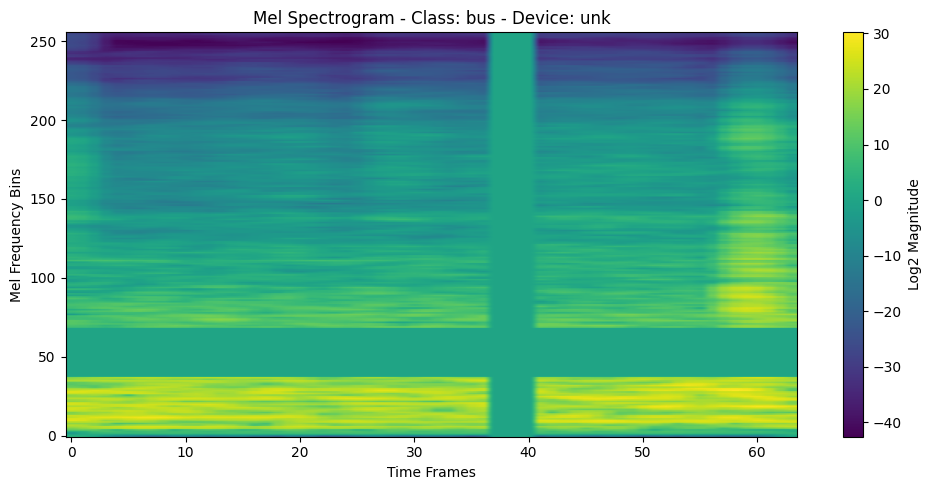



Testing Data Shapes:
  Waveforms: torch.Size([1024, 1, 256, 64]) (batch_size, mel_bins, time_steps)



In [8]:
analyze_data_shapes(train_loader, "Training")
for waveforms, devices, labels in train_loader:
    i = random.randint(0,params['batch_size']-1)
    plot_mel_spectrogram(waveforms[i], labels[i], get_device_name(dev=int(devices[i])))
    break

analyze_data_shapes(test_loader, "Testing")
# for waveforms, devices, labels in test_loader:
    # i = random.randint(0,params['batch_size']-1)
    # plot_mel_spectrogram(waveforms[i], labels[i], get_device_name(dev=int(devices[i])))
    # break

# Defining Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RepConv2d(nn.Module):
    def __init__(self, input_channel, output_channel, stride=(1, 1), groups=1):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.stride = stride

        # Initial convolutions
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 3),
                               stride=stride, padding=(1, 1), bias=False,groups=groups)
        self.conv2 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 3),
                               stride=stride, padding=(0, 1), bias=False,groups=groups)
        self.conv3 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 1),
                               stride=stride, padding=(1, 0), bias=False,groups=groups)
        self.conv4 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 1),
                               stride=stride, padding=(0, 0), bias=False,groups=groups)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        return x1 + x2 + x3 + x4

    def merge_convs(self):
        conv2ds_list = [self.conv1, self.conv2, self.conv3, self.conv4]
        main_shape = conv2ds_list[0].weight.data.shape
        device = conv2ds_list[0].weight.device  # Get device from one of the convs

        # Initialize zero tensors on the correct device
        conv1 = conv2ds_list[0].weight.data
        conv2 = torch.zeros(main_shape, device=device)
        conv3 = torch.zeros(main_shape, device=device)
        conv4 = torch.zeros(main_shape, device=device)

        # Fill the corresponding parts
        conv2[:, :, 1, :] = conv2ds_list[1].weight.data.squeeze(2)
        conv3[:, :, :, 1] = conv2ds_list[2].weight.data.squeeze(3)
        conv4[:, :, 1, 1] = conv2ds_list[3].weight.data.squeeze(3).squeeze(2)

        # Create new Conv2d layer on same device
        conv2d = nn.Conv2d(
            in_channels=self.conv1.in_channels,
            out_channels=self.conv1.out_channels,
            kernel_size=self.conv1.kernel_size,
            stride=self.conv1.stride,
            padding=self.conv1.padding,
            bias=False,
            groups=self.conv1.groups
        ).to(device)

        with torch.no_grad():
            conv2d.weight.copy_((conv1 + conv2 + conv3 + conv4))

        return conv2d

    def get_reparametrized_layer(self):
        conv2d = self.merge_convs()
        return nn.Sequential(conv2d)


class ResidualNormalization(nn.Module):
    """
    Combined normalization layer:
    λ * x + InstanceNorm(x)
    """
    def __init__(self, num_features):
        super().__init__()
        # Learnable per-channel scaling factor
        self.lambda_param = nn.Parameter(torch.ones(num_features, 1, 1))
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=True)

    def forward(self, x):
        return self.lambda_param * x + self.instance_norm(x)


class LearnablePooling(nn.Module):
    """
    Attention-based learnable pooling with Global Average Pooling (GAP)
    Output: concat(attention_pooled_features, GAP_features)
    """
    def __init__(self, in_channels, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_channels // 2
        
        # Input normalization
        self.bn_input = ResidualNormalization(in_channels)
        
        # Attention mechanism
        self.attn_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn_attn = ResidualNormalization(hidden_dim)
        self.attn_score = nn.Conv2d(hidden_dim, in_channels, kernel_size=1, bias=False)
        self.activation = nn.LeakyReLU(0.1, inplace=True)
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Input normalization
        x_norm = self.bn_input(x)
        
        # Attention weights calculation
        attn = self.activation(self.bn_attn(self.attn_conv(x_norm)))
        scores = self.attn_score(attn)
        
        # Softmax over spatial dimensions
        b, c, h, w = x.size()
        spatial_weights = F.softmax(scores.view(b, c, -1), dim=-1).view(b, c, h, w)
        
        # Attention-weighted pooling
        attn_pooled = (x * spatial_weights).sum(dim=[2, 3])
        
        # Global average pooling
        gap_pooled = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        
        # Concatenate both pooling results
        return torch.cat([attn_pooled, gap_pooled], dim=1)


class DSFlexiNetBlock(nn.Module):
    """Inverted Residual Block with Expansion and RepConv"""
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super().__init__()
        self.stride = stride
        self.use_skip = True
        mid_channels = in_channels * expansion_factor
        
        # ---- Input normalization and scaling ----
        self.input_norm = nn.BatchNorm2d(in_channels)
        self.input_scaling = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False) if self.use_skip else None
        
        # ---- Expansion convolution ----
        self.expand_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False)
        self.expand_norm = nn.BatchNorm2d( out_channels )
        self.expand_activation = nn.LeakyReLU()
        
        # ---- Spatial convolution ----
        self.spatial_conv = RepConv2d( out_channels , out_channels, stride=stride, groups = out_channels)
        self.spatial_norm = nn.BatchNorm2d( out_channels )
        self.spatial_activation = nn.LeakyReLU()
        
    def forward(self, x):
        residual = self.input_scaling(x) if self.use_skip else None
        
        # Input normalization
        out = self.input_norm(x)
        
        # Expansion
        out = self.expand_conv(out)
        out = self.expand_activation(out)
        
        # Spatial processing
        out = self.spatial_norm(out)
        out = self.spatial_conv(out)
        out = self.spatial_activation(out)

        # Residual connection
        return out + residual if self.use_skip else out


class DSFlexiNet(nn.Module):
    """Main Network Architecture with RepConv and Flexible Blocks"""
    def __init__(self, num_classes=10):
        super().__init__()       
        # ---- Initial Convolution Layers ----
        self.input_norm = nn.BatchNorm2d(1)
        
        # Stage 1: Downsample
        self.conv1 = RepConv2d(1, 16, stride = ( 2 , 2) )
        self.norm1 = nn.BatchNorm2d(16)
        self.activation1 = nn.ReLU()
        # Stage 2: Downsample
        self.conv2 = RepConv2d( 16 , 32 , stride = ( 2 , 2) )
        self.activation2 = nn.ReLU()
        
        # ---- Residual Stages ----
        # Stage 1: Residual blocks
        self.stage1 = nn.Sequential(
            DSFlexiNetBlock(32, 32, stride=(1,1)),
            DSFlexiNetBlock(32, 32, stride=(1,1)),
            DSFlexiNetBlock(32, 32, stride=(1,1))
        )
        self.stage1_norm = ResidualNormalization(32)
        
        # Stage 2: Residual blocks
        self.stage2 = nn.Sequential(
            DSFlexiNetBlock(32, 32, stride=(1,1)),
            DSFlexiNetBlock(32 , 32, stride=(1,1)),
            DSFlexiNetBlock(32 , 32, stride=(1,1)),
        )
        self.stage2_norm = ResidualNormalization(32)
        
        # Stage 3: Final residual block
        self.stage3 = nn.Sequential(
            DSFlexiNetBlock(32 , 64 , stride=(1,1)),
        )
        
        self.stage3_norm = ResidualNormalization(64)
        
        # ---- Classification Head ----
        self.pooling = LearnablePooling(64)
        self.head_norm = nn.BatchNorm1d(64 * 2)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(64 * 2, num_classes)

    def forward(self, x , device = None):
        # Input preprocessing
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        x = self.input_norm(x)
        # Initial convolution stages
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        
        # Residual stages with skip connections
        x = self.stage1(x) + x
        x = self.stage1_norm(x)
        
        x = self.stage2(x) + x
        x = self.stage2_norm(x)
        
        x = self.stage3(x)
        x = self.stage3_norm(x)
        
        # Classification head
        x = self.pooling(x)
        x = self.head_norm(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [10]:
# Initialize model and move to device
model = DSFlexiNet().to(device)

ReParametrize(model,device=device)

dummy_input = torch.randn((1, 1, params['nb_mels'], params['mel_seq_len'])).to(device)   # batch_size, channel, fre, time
dummy_device = torch.randint(0, 6, size=(1,)).to(device)
# using float16 is optional
model = model.half()
dummy_input = dummy_input.half()
print(summary(model, input_data=[dummy_input,dummy_device] , depth=2, col_names=["input_size" , "output_size" , "num_params", 'mult_adds'], verbose=0))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
DSFlexiNet                               [1, 1, 256, 64]           [1, 10]                   --                        --
├─BatchNorm2d: 1-1                       [1, 1, 256, 64]           [1, 1, 256, 64]           2                         2
├─Sequential: 1-2                        [1, 1, 256, 64]           [1, 16, 128, 32]          --                        --
│    └─Conv2d: 2-1                       [1, 1, 256, 64]           [1, 16, 128, 32]          144                       589,824
├─ReLU: 1-3                              [1, 16, 128, 32]          [1, 16, 128, 32]          --                        --
├─BatchNorm2d: 1-4                       [1, 16, 128, 32]          [1, 16, 128, 32]          32                        32
├─Sequential: 1-5                        [1, 16, 128, 32]          [1, 32, 64, 16]           --                        --
│    └─Conv2d

# Train Pipeline



STEP 1 --------------------------------------------------------------------
Model loaded from /kaggle/input/dcase2025-task1-branch1/best_model_step1.pth

Epoch 1/250
  Training - Loss: 1.2238, Accuracy: 55.4%
        a    	unk  	c    	s3   	s1   	b    	s2   
        56.7%	55.4%	55.9%	48.1%	47.9%	55.6%	49.0%
  Validation - Loss: 1.9161, Best Loss: inf, Accuracy: 42.1%, Best Acc: 0.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        41.3%	44.4%	37.9%	53.7%	38.6%	47.8%	39.6%

Epoch 2/250
  Training - Loss: 1.2379, Accuracy: 55.0%
        unk  	a    	s3   	s1   	c    	s2   	b    
        55.0%	56.5%	48.0%	46.2%	54.0%	47.0%	55.0%
  Validation - Loss: 1.7633, Best Loss: 1.9161, Accuracy: 45.4%, Best Acc: 42.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.0%	48.2%	43.2%	51.9%	41.3%	46.6%	45.6%

Epoch 3/250
  Training - Loss: 1.2337, Accuracy: 55.0%
        unk  	a    	s3   	s2   	b    	c    	s1   
        55.1%	56.3%	47.1%	49.0%	55.8%	51.6%	45.6%
  Validation - Loss: 

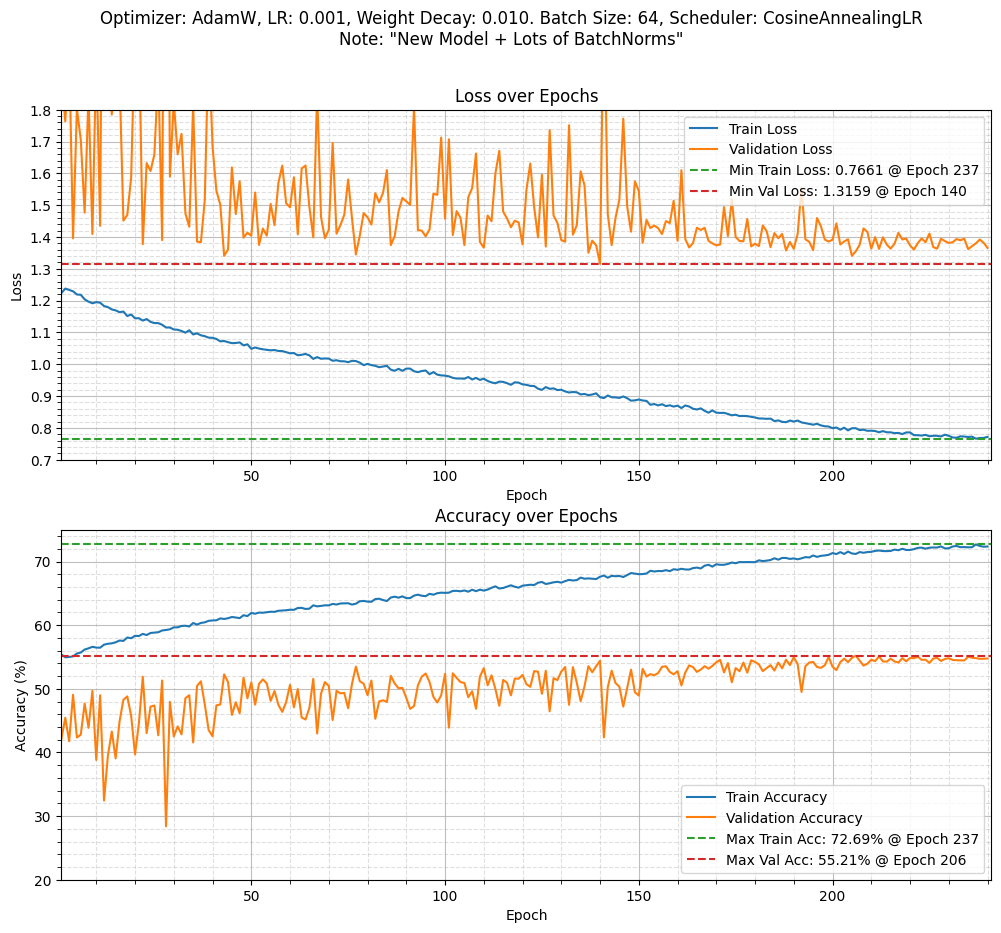

In [11]:
print("\n\nSTEP 1 --------------------------------------------------------------------")
model = DSFlexiNet().to(device)


# We first train the model for 100 epochs. Then, we restart the optimizer and scheduler, load the best model obtained so far, and train it for another 100 epochs. We repeat this process with 150 epochs, and finally train for an additional 250 epochs in the same manner.
if params['loadmodel'] != None:
    print("Model loaded from " + params['loadmodel'])
    model.load_state_dict(torch.load(params['loadmodel'], map_location=device)['model_state_dict'])

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'])
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['nb_epochs'])
# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)
# Evaluation metric
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

model, best_acc, best_loss, train_losses, train_accs, val_losses, val_accs= train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler= scheduler,
    loss_fn=loss_fn,
    metric=metric,
    params=params,
    best_test_accuracy = 0.0,
    best_val_loss = float('inf'),
    model_name="step1",
)


print("\n\nReparametrization + Half --------------------------------------------------------------------")
ReParametrize(model,device)
model = model.half()
# Validate
test_loss, test_acc, test_device_stats = evaluate_epoch(
    model, test_loader, loss_fn, metric, best_loss, best_acc, half=True
)
    

# Get optimizer name
optimizer_name = optimizer.__class__.__name__
schdlr = scheduler.__class__.__name__ if scheduler != None else "None"
wd = optimizer.param_groups[0]['weight_decay']
NOTE = "New Model + Lots of BatchNorms"
plot_training_history(train_losses, train_accs, val_losses, val_accs, details=f"Optimizer: {optimizer_name}, LR: {params['learning_rate']}, Weight Decay: {wd:1.3f}. Batch Size: {params['batch_size']}, Scheduler: {schdlr}\nNote: \"{NOTE}\"")